In [46]:
!pip install yfinance

In [47]:
# Calibration and Parameter Estimation for GARCH(1,1) Model

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')
from scipy.optimize import minimize, differential_evolution
import time

In [63]:
# Download 'AMZN' stock data

data = yf.download('AMZN', start='2020-01-01', end='2025-01-01')
data = data.dropna()

/var/folders/r5/2g_68vlx2mz26421nzw8jqv40000gn/T/ipykernel_13232/1609790539.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AMZN', start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [64]:
data['Close', 'AMZN']

Date
2020-01-02     94.900497
2020-01-03     93.748497
2020-01-06     95.143997
2020-01-07     95.343002
2020-01-08     94.598503
                 ...    
2024-12-24    229.050003
2024-12-26    227.050003
2024-12-27    223.750000
2024-12-30    221.300003
2024-12-31    219.389999
Name: (Close, AMZN), Length: 1258, dtype: float64

In [65]:
# Daily returns

data['returns', 'AMZN'] = data['Close', 'AMZN'].pct_change()+1
data

Price,Close,High,Low,Open,Volume,returns
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,NaN
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000,0.987861
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000,1.014886
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000,1.002092
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000,0.992191
...,...,...,...,...,...,...
2024-12-24,229.050003,229.139999,226.130005,226.940002,15007500,1.017729
2024-12-26,227.050003,228.500000,226.669998,228.500000,16146700,0.991268


In [66]:
# Log returns

returns = np.log(data['returns', 'AMZN']).dropna().values*100
print(f"Loaded {len(returns)} daily returns.")
returns = np.array(returns)
returns

Loaded 1257 daily returns.


array([-1.22133145,  1.47758711,  0.2089436 , ..., -1.46409138,
       -1.10100963, -0.86682957])

In [67]:
# Define GARCH(1,1) negative log-likelihood

def garch_negloglik(params, returns, mu=0.0):
    omega, alpha, beta = params
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 0.9999:
        return 1e12
    times = len(returns)
    sigma2 = np.zeros(times)
    sigma2[0] = np.var(returns)
    for t in range(1, times):
        sigma2[t] = omega + alpha * (returns[t-1]-mu)**2 + beta * sigma2[t-1]
        if sigma2[t] <= 0:
            return 1e12
    ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + (returns-mu)**2 / sigma2)
    return -ll

In [68]:
# Calibration settings

initials = [1e-6, 0.05, 0.9]
bounds = [(1e-12, 1e-2), (0.0, 1.0), (0.0, 0.9999)]
results = []

In [69]:
# Method 1: L-BFGS-B

t0 = time.time()
res_lbfgs = minimize(lambda x: garch_negloglik(x, returns), initials, method='L-BFGS-B', bounds=bounds)
t1 = time.time()
results.append({'method': 'L-BFGS-B', 'time_s': t1-t0, 'params': res_lbfgs.x, 'fun': res_lbfgs.fun})
results

[{'method': 'L-BFGS-B',
  'time_s': 0.1375102996826172,
  'params': array([0.00222241, 0.0827084 , 0.91680578]),
  'fun': np.float64(2766.301932063942)}]

In [70]:
# Method 2: Differential Evolution

t0 = time.time()
res_de = differential_evolution(lambda x: garch_negloglik(x, returns), bounds=bounds, maxiter=1000, polish=True)
t1 = time.time()
results.append({'method': 'Differential Evolution', 'time_s': t1-t0, 'params': res_de.x, 'fun': res_de.fun})
results

[{'method': 'L-BFGS-B',
  'time_s': 0.1375102996826172,
  'params': array([0.00222241, 0.0827084 , 0.91680578]),
  'fun': np.float64(2766.301932063942)},
 {'method': 'Differential Evolution',
  'time_s': 0.32837510108947754,
  'params': array([0.00933208, 0.02317734, 0.97463317]),
  'fun': np.float64(2755.4674779931156)}]

In [71]:
# Method 3: SLSQP

t0 = time.time()
res_lbfgs = minimize(lambda x: garch_negloglik(x, returns), initials, method='SLSQP', bounds=bounds)
t1 = time.time()
results.append({'method': 'SLSQP', 'time_s': t1-t0, 'params': res_lbfgs.x, 'fun': res_lbfgs.fun})
results

/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[{'method': 'L-BFGS-B',
  'time_s': 0.1375102996826172,
  'params': array([0.00222241, 0.0827084 , 0.91680578]),
  'fun': np.float64(2766.301932063942)},
 {'method': 'Differential Evolution',
  'time_s': 0.32837510108947754,
  'params': array([0.00933208, 0.02317734, 0.97463317]),
  'fun': np.float64(2755.4674779931156)},
 {'method': 'SLSQP',
  'time_s': 0.10919618606567383,
  'params': array([0.01      , 0.03473696, 0.96487219]),
  'fun': np.float64(2753.9175328238575)}]

In [72]:
# Comparing 3 methods
results_df = pd.DataFrame([{
    'Method': r['method'],
    'Time (s)': round(r['time_s'], 3),
    'Omega': r['params'][0],
    'Alpha': r['params'][1],
    'Beta': r['params'][2],
    'NegLogLik': r['fun']
} for r in results])
print("Calibration performance comparison:")
print(results_df)

Calibration performance comparison:
                   Method  Time (s)     Omega     Alpha      Beta    NegLogLik
0                L-BFGS-B     0.138  0.002222  0.082708  0.916806  2766.301932
1  Differential Evolution     0.328  0.009332  0.023177  0.974633  2755.467478
2                   SLSQP     0.109  0.010000  0.034737  0.964872  2753.917533


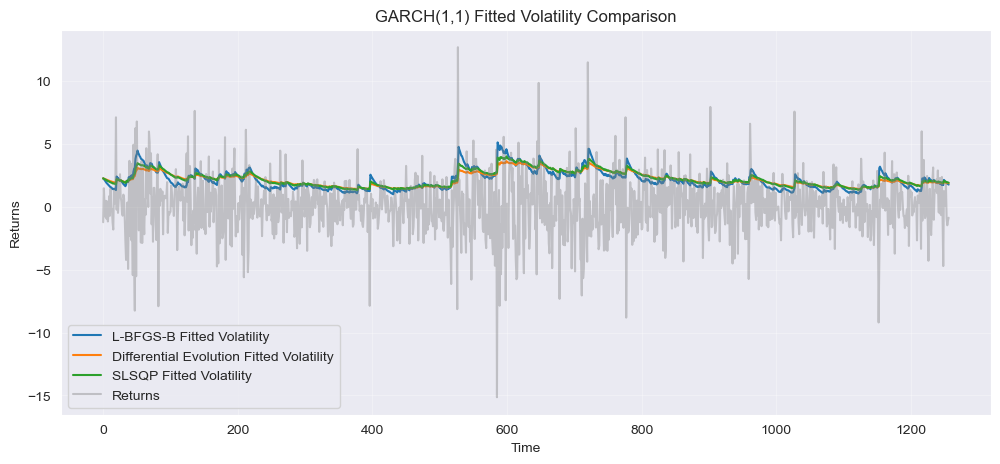

In [84]:
# Fitted volatility comparison

methods = ['L-BFGS-B', 'Differential Evolution', 'SLSQP']

plt.figure(figsize=(12,5))

for method in methods:
    row = results_df.loc[results_df['Method'] == method].iloc[0]
    omega, alpha, beta = row['Omega'], row['Alpha'], row['Beta']
    
    sigma2 = np.zeros(len(returns))
    sigma2[0] = np.var(returns)
    for t in range(1, len(returns)):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    plt.plot(np.sqrt(sigma2), label=f'{method} Fitted Volatility')

plt.plot(returns, label='Returns', color='gray', alpha=0.4)

plt.title('GARCH(1,1) Fitted Volatility Comparison')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(alpha=0.3)

plt.savefig("Plot1.png")
plt.show()

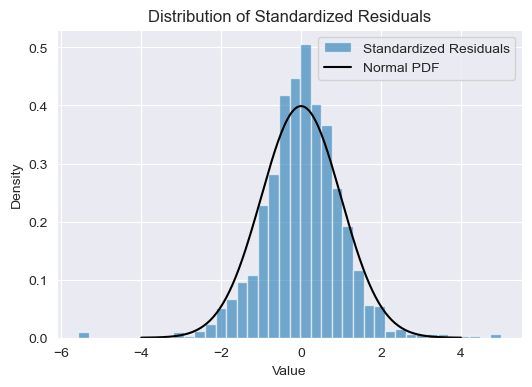

In [74]:
# Histogram and distribution fit

residuals = returns / np.sqrt(sigma2)
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, density=True, alpha=0.6, label='Standardized Residuals')

x = np.linspace(-4,4,200)
plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2), label='Normal PDF', color='black')
plt.title('Distribution of Standardized Residuals')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.savefig("Plot2.png")
plt.show()

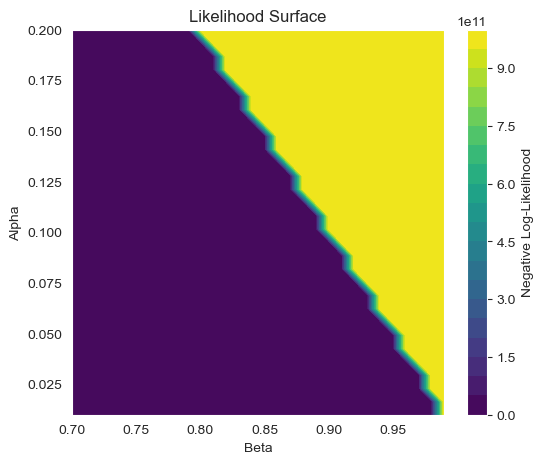

In [83]:
# 2D likelihood surface

best_row = results_df.loc[results_df['NegLogLik'].idxmin()]
best_params = [best_row['Omega'], best_row['Alpha'], best_row['Beta']]

alphas = np.linspace(0.01, 0.2, 30)
betas = np.linspace(0.7, 0.99, 30)
Z = np.zeros((len(alphas), len(betas)))

for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        Z[i,j] = garch_negloglik([best_params[0], a, b], returns)

plt.figure(figsize=(6,5))
plt.contourf(betas, alphas, Z, 20, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.title('Likelihood Surface')

plt.savefig("Plot3.png")
plt.show()

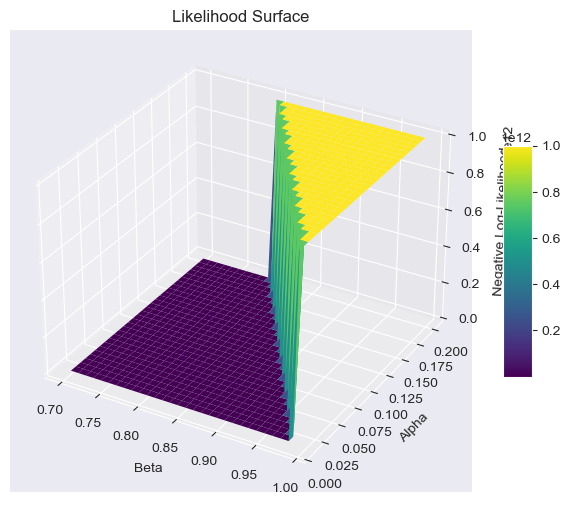

In [76]:
# 3D likelihood surface

best_row = results_df.loc[results_df['NegLogLik'].idxmin()]
best_params = [best_row['Omega'], best_row['Alpha'], best_row['Beta']]

alphas = np.linspace(0.01, 0.2, 30)
betas = np.linspace(0.7, 0.99, 30)
Z = np.zeros((len(alphas), len(betas)))

for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        Z[i, j] = garch_negloglik([best_params[0], a, b], returns)

A, B = np.meshgrid(betas, alphas)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A, B, Z, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Beta')
ax.set_ylabel('Alpha')
ax.set_zlabel('Negative Log-Likelihood')
ax.set_title('Likelihood Surface')
fig.colorbar(surf, shrink=0.5, aspect=8)

plt.savefig("Plot4.png")
plt.show()

/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


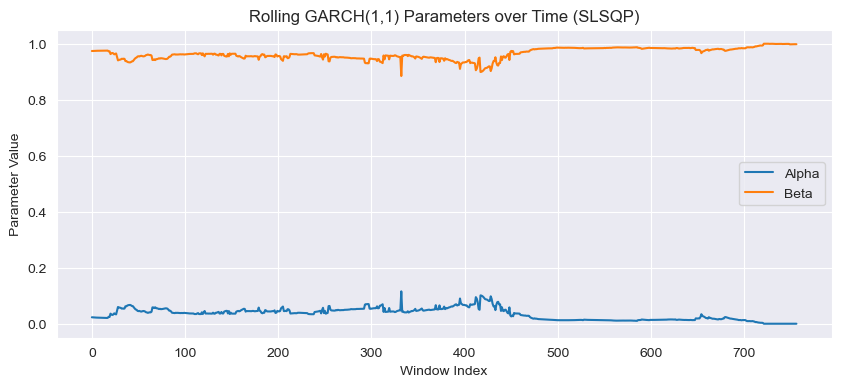

In [85]:
# Alpha vs Beta

window = 500
rolling_alpha, rolling_beta = [], []
for i in range(len(returns) - window):
    r_window = returns[i:i+window]
    res = minimize(lambda x: garch_negloglik(x, r_window), initials, method='SLSQP', bounds=bounds)
    rolling_alpha.append(res.x[1])
    rolling_beta.append(res.x[2])

plt.figure(figsize=(10,4))
plt.plot(rolling_alpha, label='Alpha')
plt.plot(rolling_beta, label='Beta')
plt.title('Rolling GARCH(1,1) Parameters over Time (SLSQP)')
plt.xlabel('Window Index')
plt.ylabel('Parameter Value')
plt.legend()

plt.savefig("Plot5.png")
plt.show();